# Dataset analysis and preparation

Analysis of the GTSRB dataset and creation of an enhanced dataset

## Objectives :

- Understand the complexity associated with data, even when it is only images
- Learn how to build up a simple and usable image dataset

The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.The final aim is to recognise them !

# Step 1 - Import and Init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from sklearn.utils import shuffle

from importlib import reload


## Step 2 - Parameters
The generation of datasets may require some time and space : **10' and 10 GB**.  

You can choose to perform tests or generate the whole enhanced dataset by setting the following parameters:  
`scale` : 1 mean 100% of the dataset - set 0.2 for tests (need 2 minutes with scale = 0.2)  
`progress_verbosity`: Verbosity of progress bar: 0=silent, 1=progress bar, 2=One line  
`output_dir` : where to write enhanced dataset, could be :
 - `./data`, for tests purpose
 - `<datasets_dir>/GTSRB/enhanced` to add clusters in your datasets dir.  

In [2]:
# ---- For smart tests :
#
scale      = 0.2
output_dir = './data' 

# ---- For a Full dataset generation :
#
# scale      = 1
# output_dir = f'{datasets_dir}/GTSRB/enhanced'

# ---- Verbosity
#
progress_verbosity = 2

# Step 3 - Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations : `GT-<ClassID>.csv` and the training images
 - First line is fieldnames: `Filename ; Width ; Height ; Roi.X1 ; Roi.Y1 ; Roi.X2 ; Roi.Y2 ; ClassId`
    
## 3.1 - Understanding the dataset

In [4]:
df = pd.read_csv(f'GTSRB/origine/Test.csv', header=0)
df.head(10) 


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


In [5]:
df = pd.read_csv(f'GTSRB/origine/Train.csv', header=0)
df.head(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
5,31,27,6,5,26,22,20,Train/20/00020_00000_00005.png
6,31,28,6,6,26,23,20,Train/20/00020_00000_00006.png
7,31,28,6,6,26,23,20,Train/20/00020_00000_00007.png
8,31,29,5,6,26,24,20,Train/20/00020_00000_00008.png
9,34,32,6,6,29,26,20,Train/20/00020_00000_00009.png


In [6]:
df = pd.read_csv(f'GTSRB/origine/Meta.csv', header=0)
df.head(10)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


## 3.2 - Usefull functions
A nice function for reading a dataset from an index.csv file.\
Input: an intex.csv file\
Output: an array of images ans an array of corresponding labels

In [7]:
def read_csv_dataset(csv_file):
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv_file (str): Description file, Example /data/GT-Train.csv
        progress_verbosity (int): Verbosity level of progress update, default is 1 (on)
    Returns:
        x, y (tuple): np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)

    # ---- Read csv file
    df = pd.read_csv(csv_file, header=0)
    
    # ---- Get filenames and ClassIds
    filenames = df['Path'].to_list()
    y = df['ClassId'].to_list()
    x = []
    
    # ---- Read images
    for filename in tqdm(filenames, disable=(progress_verbosity == 0), desc="Loading Images"):
        image = io.imread(os.path.join(path, filename))
        x.append(image)
    
    # ---- Return
    return np.array(x, dtype=object), np.array(y)


## 3.2 - Read the data
We will read the following datasets:
 - **Train** subset, for learning data as :  `x_train, y_train`
 - **Test** subset, for validation data as :  `x_test, y_test`
 - **Meta** subset, for visualisation as : `x_meta, y_meta`
 
The learning data will be randomly mixted and the illustration data (Meta) sorted.  
Will take about 1'30s on HPC or 45s on my labtop.

In [10]:
# Démarrer le chronomètre
start_time = time.time()

# ---- Lire les datasets
(x_train, y_train) = read_csv_dataset(f'GTSRB/origine/Train.csv')
(x_test, y_test) = read_csv_dataset(f'GTSRB/origine/Test.csv')
(x_meta, y_meta) = read_csv_dataset(f'GTSRB/origine/Meta.csv')
    
# ---- Mélanger le jeu de données d'entraînement
x_train, y_train = shuffle(x_train, y_train, random_state=0)

# ---- Trier Meta
combined = list(zip(x_meta, y_meta))
combined.sort(key=lambda x: x[1])
x_meta, y_meta = zip(*combined)

# Afficher le temps écoulé
end_time = time.time()
print(f'Temps écoulé: {end_time - start_time} secondes')


Loading Images:   0%|          | 0/39209 [00:00<?, ?it/s]

Loading Images: 100%|██████████| 43/43 [00:00<00:00, 1120.98it/s]

Temps écoulé: 34.59719181060791 secondes


# Step 4 - Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

## 4.1 - Do statistics

In [11]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

## 4.2 - Show statistics

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


NameError: name 'fidle' is not defined

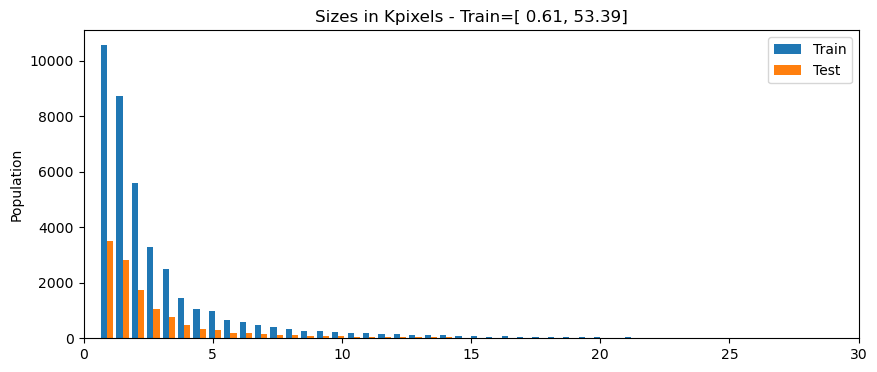

In [12]:
figsize=(10,4)
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=figsize)
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
plt.savefig('01-stats-sizes.png')
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=figsize)
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.savefig('02-stats-ratios.png')
plt.show()

# ------ Statistics / lx
plt.figure(figsize=figsize)
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.savefig('03-stats-lx.png')
plt.show()

# ------ Statistics / ly
plt.figure(figsize=figsize)
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
plt.savefig('04-stats-ly.png')
plt.show()

# ------ Statistics / classId
plt.figure(figsize=figsize)
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
plt.savefig('05-stats-classes.png')
plt.show()